# Prediction of movie genres based on plot summary – A Multi Label Classification problem

### Student ID: 6642808
### Name        : Jisa Mithun
### Group       : 07

### Table of Contents

* [1. Introduction](#chapter1)
* [2. Dataset Overview](#chapter2)
* [3. Exploratory Data Analysis (EDA)](#chapter3)
    * [3.1 Analysis of Genres](#section_3_1)
    * [3.2 Selection of Genres](#section_3_2)
    * [3.3 Word Cloud Plots](#section_3_3)
* [4. Data Preprocessing](#chapter4)
* [5. Model Training and Evaluation](#chapter5)
    * [5.1 Train and Test Split](#section_5_1)
    * [5.2 OneVsRest Classifier](#section_5_2)
    * [5.3 Binary Relevance](#section_5_3)
    * [5.4 Classifier Chains](#section_5_4)
    * [5.5 Label Power Set](#section_5_5)
* [6. Results and Conclusion](#chapter6)

### 1. Introduction <a class="anchor" id="chapter1"></a>

Classification of text has become fundamental tasks in natural language processing. There are a wide range of areas where text classification are used like binary classification used for classifying emails as "spam" or "not a spam". It can be a multi-class problem where each instance of the data is associated with one of many classes for e.g. classifying the articles in the news into categories like Food, sports, politics, etc. It can be also a multi-label classification problem where each instance is associated with one or more classes.

The main of this coursework is to work on a multi-label classification problem where we will use the CMU Movie Corpus Dataset that contains several information about the movies like Movie name, genres, languages, etc. We will use this dataset to build a multi-label classification model to predict different genres based on the plot description.

The scope of this Jupyter notebook is the individual coursework, where I will be carrying out exploratory data analysis, experimenting with TFIDF Text Featurization and use Naive Bayes model to predict the genres of the movies based on the plot summary. 

### 2. Dataset Overview <a class="anchor" id="chapter2"></a>

CMU Movie Summary Corpus is a multi-label data set with 42,306 movie plot summaries extracted from
Wikipedia + Freebase, including: Movie box office revenue, genre, release date, runtime, and language. There are
363 unique genres in the dataset. The dataset can be downloaded from this link http://www.cs.cmu.edu/~ark/personas/.

The only files that we will use from the dataset is "movie.metadata.tsv" and "plot_summaries.txt".
1. *movie.metadata.tsv: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  
Tab-separated; columns: Wikipedia movie ID, Freebase movie ID, Movie name, Movie release date, Movie box office revenue, Movie runtime, Movie languages, Movie countries, Movie genres.

2. *plot_summaries.txt: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

*Make sure the movie.metadata.tsv and plot_summaries.txt are in the same directory as the jupyter notebook.

In [1]:
!pip install scikit-multilearn
!pip install wordcloud

You should consider upgrading via the 'd:\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
#Import the required libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns
import re
import math
import unicodedata
import nltk
from wordcloud import WordCloud
from datetime import datetime

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords,wordnet

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Jisa
[nltk_data]     Mithun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jisa
[nltk_data]     Mithun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Get movie metadata 
metadata = pd.read_csv("movie.metadata.tsv", sep = '\t', header = None)
# rename columns
metadata.columns = ["Wikipedia_movie_ID","Freebase_movie_ID","Movie_name","Movie_release_date",
                    "Movie_box_office revenue","Movie_runtime","Movie_languages","Movie_countries","Movie_genres"]
metadata.head()

Wikipedia_movie_ID Freebase_movie_ID  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          Movie_name Movie_release_date  \
0                                     Ghosts of Mars         2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                        Brun bitter               1988   
3                                   White Of The Eye               1987   
4                                  A Woman in Flames               1983   

   Movie_box_office revenue  Movie_runtime  \
0                14010832.0           98.0   
1                       NaN           95.0   
2                       NaN           83.0   
3                       NaN          110.0   
4                       NaN          106.0   

                      Movie_languages  \
0  {"/m/02h40lc": "English Language"}   
1  {"/m/02h40lc": "English Language"}   
2  {"/m/05f_3": "Norwegian Language"}   
3  {"/m/02h40lc": "English Language"}   
4   {"/m/04306rv": "German Language"}   

                             Movie_countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                        Movie_genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                            {"/m/07s9rl0": "Drama"}

In [4]:
#Get the plot information for the movies
movie_plots = pd.read_csv("plot_summaries.txt",delimiter='\t', header = None)
movie_plots.columns = ["Wikipedia_movie_ID", "Plot_Summary"]
movie_plots.head()

Wikipedia_movie_ID                                       Plot_Summary
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...
1            31186339  The nation of Panem consists of a wealthy Capi...
2            20663735  Poovalli Induchoodan  is sentenced for six yea...
3             2231378  The Lemon Drop Kid , a New York City swindler,...
4              595909  Seventh-day Adventist Church pastor Michael Ch...

In [5]:
# Merge Metadata and Movie plot summary based on Wikipedia_movie_ID
movies = pd.merge(movie_plots, metadata[['Wikipedia_movie_ID', 'Movie_genres']], on = 'Wikipedia_movie_ID')
movies.head()

Wikipedia_movie_ID                                       Plot_Summary  \
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1            31186339  The nation of Panem consists of a wealthy Capi...   
2            20663735  Poovalli Induchoodan  is sentenced for six yea...   
3             2231378  The Lemon Drop Kid , a New York City swindler,...   
4              595909  Seventh-day Adventist Church pastor Michael Ch...   

                                        Movie_genres  
0  {"/m/07s9rl0": "Drama", "/m/03q4nz": "World ci...  
1  {"/m/03btsm8": "Action/Adventure", "/m/06n90":...  
2  {"/m/04t36": "Musical", "/m/02kdv5l": "Action"...  
3  {"/m/06qm3": "Screwball comedy", "/m/01z4y": "...  
4  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...

In [6]:
#remove unwanted characters from Movie Genres
def get_genres(movie_genres):
    return list(json.loads(movie_genres).values())

movies['Movie_genres'] = movies['Movie_genres'].apply(get_genres)
movies.head()

Wikipedia_movie_ID                                       Plot_Summary  \
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1            31186339  The nation of Panem consists of a wealthy Capi...   
2            20663735  Poovalli Induchoodan  is sentenced for six yea...   
3             2231378  The Lemon Drop Kid , a New York City swindler,...   
4              595909  Seventh-day Adventist Church pastor Michael Ch...   

                                        Movie_genres  
0                              [Drama, World cinema]  
1  [Action/Adventure, Science Fiction, Action, Dr...  
2                [Musical, Action, Drama, Bollywood]  
3                         [Screwball comedy, Comedy]  
4  [Crime Fiction, Drama, Docudrama, World cinema...

In [7]:
#Check for empty labels in Movie_genres
(movies['Movie_genres'].str.len() == 0).value_counts()

False    41793
True       411
Name: Movie_genres, dtype: int64

In [8]:
movies_dataset = movies[~(movies['Movie_genres'].str.len() == 0)]
movies_dataset = movies_dataset.reset_index(drop=True)

print("Total number of samples in data =",movies_dataset.shape[0])
print("\n")
print("**Sample data:**")
movies_dataset.head()

Total number of samples in data = 41793


**Sample data:**


Wikipedia_movie_ID                                       Plot_Summary  \
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1            31186339  The nation of Panem consists of a wealthy Capi...   
2            20663735  Poovalli Induchoodan  is sentenced for six yea...   
3             2231378  The Lemon Drop Kid , a New York City swindler,...   
4              595909  Seventh-day Adventist Church pastor Michael Ch...   

                                        Movie_genres  
0                              [Drama, World cinema]  
1  [Action/Adventure, Science Fiction, Action, Dr...  
2                [Musical, Action, Drama, Bollywood]  
3                         [Screwball comedy, Comedy]  
4  [Crime Fiction, Drama, Docudrama, World cinema...

In [9]:
movies_dataset.to_csv('movie_dataset.csv', index=False)
movies_dataset.head()

Wikipedia_movie_ID                                       Plot_Summary  \
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1            31186339  The nation of Panem consists of a wealthy Capi...   
2            20663735  Poovalli Induchoodan  is sentenced for six yea...   
3             2231378  The Lemon Drop Kid , a New York City swindler,...   
4              595909  Seventh-day Adventist Church pastor Michael Ch...   

                                        Movie_genres  
0                              [Drama, World cinema]  
1  [Action/Adventure, Science Fiction, Action, Dr...  
2                [Musical, Action, Drama, Bollywood]  
3                         [Screwball comedy, Comedy]  
4  [Crime Fiction, Drama, Docudrama, World cinema...

### 3. Exploratory Data Analysis <a class="anchor" id="chapter3"></a>

#### 3.1 Analysis of Genres<a class="anchor" id="section_3_1"></a>

##### 3.1.1 Total Number of Uniques Genres

In [10]:
#Categorical conversion of labels
multilabel_binarizer = MultiLabelBinarizer()

# transform target variable
multilabel_y = pd.DataFrame(multilabel_binarizer.fit_transform(movies_dataset['Movie_genres']),columns=multilabel_binarizer.classes_) 
print("Number of samples :", multilabel_y.shape[0])
print("Number of unique Genres :", multilabel_y.shape[1])

categories = list(multilabel_binarizer.classes_)
#Lets look at the Genres we have.
print("Some of the Genres we have :", categories[:10])

Number of samples : 41793
Number of unique Genres : 363
Some of the Genres we have : ['Absurdism', 'Acid western', 'Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy']


##### 3.1.2 Number of times a Genre appears

In [11]:
freqs = multilabel_y.sum() #count frequency of each Genre
result = dict(zip(categories, freqs)) #store Genre along with its frequency

genre_table = pd.DataFrame.from_dict(result, orient="index").reset_index()
genre_table.columns = ['Genre', 'Count']
print("Few of the genres and their counts")
genre_table.head()

Few of the genres and their counts


Genre  Count
0         Absurdism     79
1      Acid western      7
2            Action   5868
3     Action Comedy    142
4  Action Thrillers    405

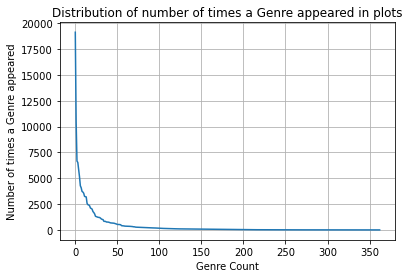

In [12]:
# Distribution of each time a Genre appeared in the plots
genre_table_sorted = genre_table.sort_values(['Count'], ascending=False)
genre_counts = genre_table_sorted['Count'].values

plt.plot(genre_counts)
plt.title("Distribution of number of times a Genre appeared in plots")
plt.grid()
plt.xlabel("Genre Count")
plt.ylabel("Number of times a Genre appeared")
plt.show()

Let's have a look at top 20 counts

In [13]:
genre_counts[:20]

array([19134, 10467,  6666,  6530,  5868,  5153,  4275,  4082,  3731,
        3668,  3553,  3248,  3219,  3192,  2572,  2441,  2414,  2339,
        2119,  2075], dtype=int64)

There are more that 2000 instances out the total 41793 instances that have the top 20 genres. 

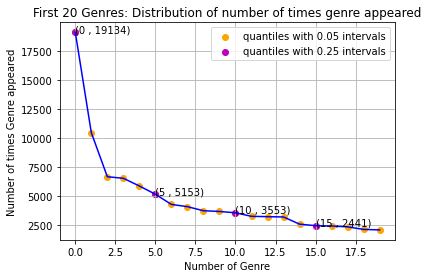

In [14]:
# Plot the number of times the first 20 genres appeared
plt.plot(genre_counts[0:20], c='b')
plt.scatter(x=list(range(0,20,1)), y=genre_counts[0:20:1], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,20,5)), y=genre_counts[0:20:5], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,20,5)), genre_counts[0:20:5]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x, y))

plt.title('First 20 Genres: Distribution of number of times genre appeared')
plt.grid()
plt.xlabel("Number of Genre")
plt.ylabel("Number of times Genre appeared")
plt.legend()
plt.show()

Reference: https://medium.datadriveninvestor.com/predicting-tags-for-the-questions-in-stack-overflow-29438367261e

In [15]:
# Store genres greater than 2K in one list
gt_2k_genres = genre_table[genre_table.Count>2000].Genre
#Print the length of the list
print ('{} Genres are used more than 2000 times'.format(len(gt_2k_genres)))

21 Genres are used more than 2000 times


##### 3.1.3 Genre per movie plot

In [16]:
label_count = multilabel_y.sum(axis=1).tolist()

print("Total Data points: ", len(label_count))
print("Maximum Number of Genres for a movie: ", max(label_count))
print("Minimum Number of Genres for a movie: ", min(label_count))
print("Average Number of Genres for a movie: ", sum(label_count)/len(label_count))

Total Data points:  41793
Maximum Number of Genres for a movie:  17
Minimum Number of Genres for a movie:  1
Average Number of Genres for a movie:  3.607637642667432


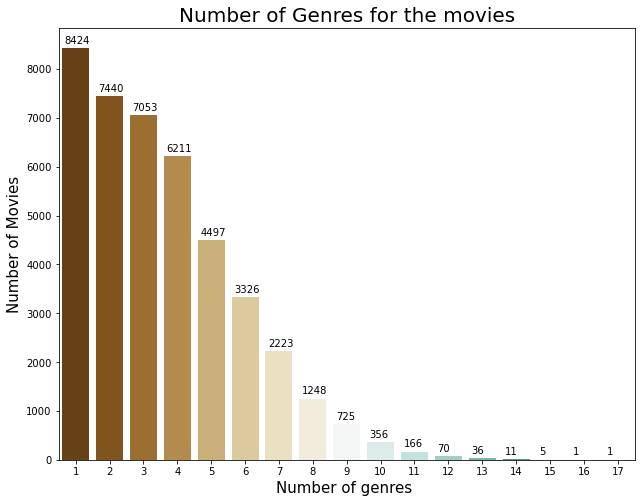

In [17]:
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
sns.countplot(label_count, palette='BrBG')
plt.title("Number of Genres for the movies", fontsize=20)
plt.ylabel('Number of Movies', fontsize=15)
plt.xlabel('Number of genres ', fontsize=15)

for i in axes.patches:
    axes.text(i.get_x()+0.08, i.get_height()+100, str(round(i.get_height(), 2)), fontsize=10, color='black')
plt.show()

##### 3.1.4 Most Frequent Genres

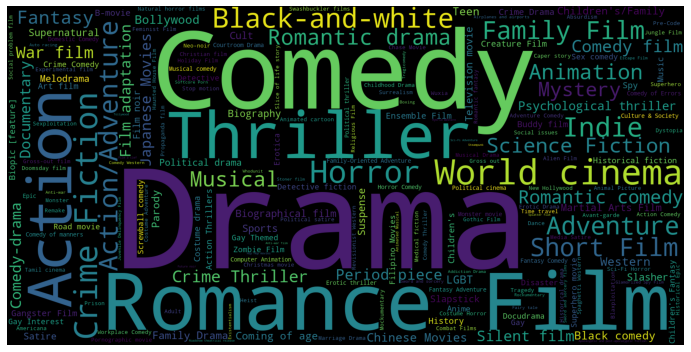

Execution Time:  0:00:02.493930


In [18]:
# Ploting word cloud
start = datetime.now()
tup = dict(result.items())
#WordCloud with frequencies of genres.
wordcloud = WordCloud(background_color='black', width=1600, height=800,).generate_from_frequencies(tup)

fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()
print("Execution Time: ", datetime.now() - start)

##### 3.1.5 Frequency of top 21 Genres

In [19]:
genre_table_sorted.head(21)

Genre  Count
114             Drama  19134
75             Comedy  10467
288      Romance Film   6666
343          Thriller   6530
2              Action   5868
359      World cinema   5153
98      Crime Fiction   4275
189            Horror   4082
43    Black-and-white   3731
196             Indie   3668
5    Action/Adventure   3553
8           Adventure   3248
137       Family Film   3219
305        Short Film   3192
290    Romantic drama   2572
19          Animation   2441
232           Musical   2414
300   Science Fiction   2339
235           Mystery   2119
289   Romantic comedy   2075
140           Fantasy   2012

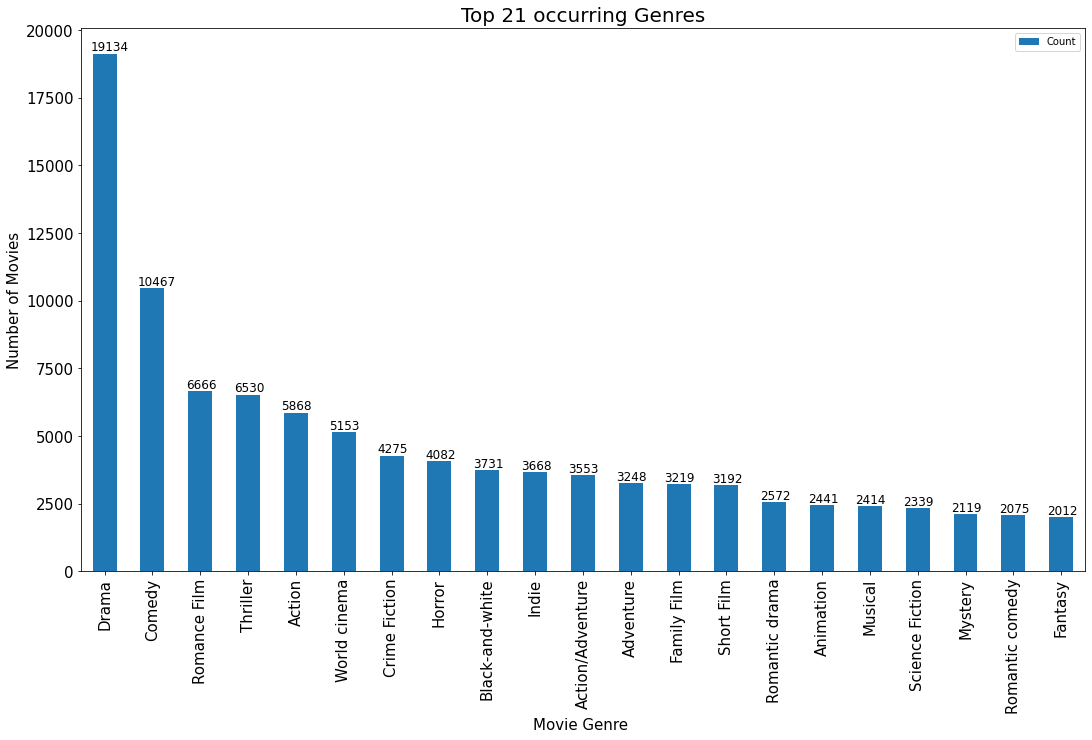

In [20]:
#Plot for top 21 genres
top_categories = genre_table_sorted.head(21)

axes = top_categories.plot(x = 'Genre', y = 'Count', kind = 'bar', figsize = (18, 10), fontsize = 15)
plt.title("Top 21 occurring Genres", fontsize = 20)
plt.ylabel('Number of Movies', fontsize=15)
plt.xlabel('Movie Genre ', fontsize=15)
plt.xticks(rotation=90)
for i in axes.patches:
    axes.text(i.get_x()-0.05, i.get_height()+100, str(round(i.get_height(), 2)), fontsize=12, color='black')
plt.show()

From the above plot we can observe that,
1. Lowest Genre movies is Fantasy (2012 movies)
2. Highest Genre movies is Drama (19134 movies), followed by Comedy (10467) and so on

#### 3.2 Selection of Genres<a class="anchor" id="section_3_2"></a>

Reference: https://medium.datadriveninvestor.com/predicting-tags-for-the-questions-in-stack-overflow-29438367261e

In [21]:
def genres_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()
    sorted_genres_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y.iloc[:,sorted_genres_i[:n]]
    return multilabel_yn

def genres_covered_fn(n):
    multilabel_yn = genres_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return np.count_nonzero(x==0),x

In [22]:
genres_covered = []    
numberOfGenres = []
total_genres = multilabel_y.shape[1]
total_plots = movies_dataset.shape[0]
for i in range(10, 50, 5):
    genres_covered.append(np.round(((total_plots-genres_covered_fn(i)[0])/total_plots)*100,3))
    numberOfGenres.append(i)

with  21 Genres we are covering nearly 93 % of Plots


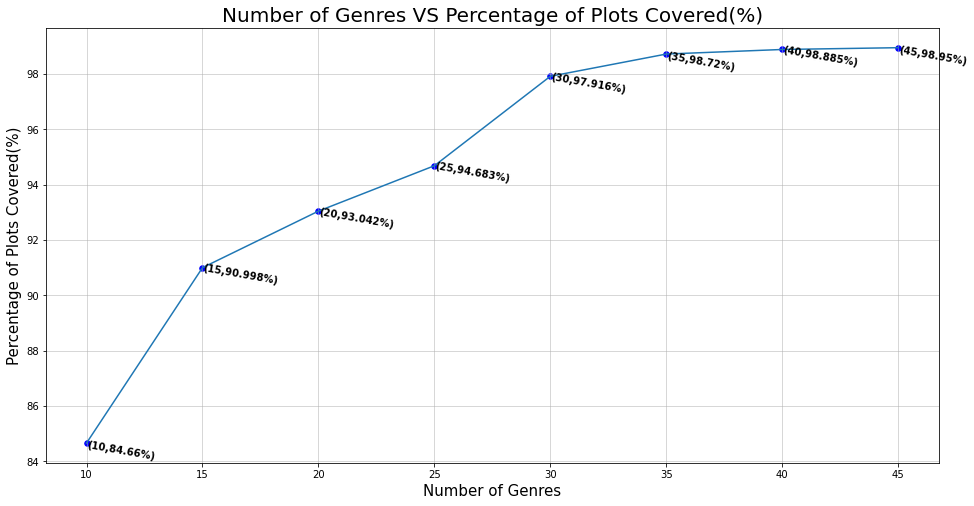

In [23]:
plt.figure(figsize = (16, 8))
plt.plot(numberOfGenres, genres_covered)
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Number of Genres VS Percentage of Plots Covered(%)", fontsize=20)
plt.xlabel("Number of Genres", fontsize=15)
plt.ylabel("Percentage of Plots Covered(%)", fontsize=15)
plt.scatter(x = numberOfGenres, y = genres_covered, c = "blue", s = 30)
for x, y in zip(numberOfGenres, genres_covered):
    plt.annotate(s = '({},{}%)'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 10, xytext=(x, y-0.6), rotation = -10)

# We select 21 Genres and it covers 93% of the samples
print("with ",21,"Genres we are covering nearly",round(genres_covered[2]),"% of Plots")

In [24]:
#Remove the labels from the dataset
sumOfRows = genres_covered_fn(21)[1]
RowIndicesZero = np.where(sumOfRows == 0)[0]  #this contains indices of all the plots for which the genres are removed
data_new = movies_dataset.drop(labels = RowIndicesZero, axis = 0)
data_new.reset_index(drop = True, inplace = True)

data_genres = genres_to_choose(21)
GenreDF_new = data_genres.drop(labels = RowIndicesZero, axis = 0)
GenreDF_new.reset_index(drop = True, inplace = True)

print("Size of new data = ",data_new.shape[0])

Size of new data =  38979


In [25]:
#This function will only keep the selected genres in the dataset
def keep_selected_genres(old_genres):
    """
    Input :- list of multiple genres from the total 363 genres
    Output :- list of multiple genres from the selected 21 genres
    """
    genres_selected = list(GenreDF_new.columns)

    new_list = []
    for i in range(len(old_genres)):
        if old_genres[i] in genres_selected:
            new_list.append(old_genres[i])
        
    return new_list

In [26]:
#Combine transformed genre data and the plot description
movie_combined = pd.concat([data_new, GenreDF_new], axis=1)
movie_combined['Movie_genres'] = movie_combined['Movie_genres'].apply(keep_selected_genres)
movie_combined.to_csv('movie_combined_dataset.csv', index=False)
movie_combined.head()

Wikipedia_movie_ID                                       Plot_Summary  \
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1            31186339  The nation of Panem consists of a wealthy Capi...   
2            20663735  Poovalli Induchoodan  is sentenced for six yea...   
3             2231378  The Lemon Drop Kid , a New York City swindler,...   
4              595909  Seventh-day Adventist Church pastor Michael Ch...   

                                        Movie_genres  Drama  Comedy  \
0                              [Drama, World cinema]      1       0   
1  [Action/Adventure, Science Fiction, Action, Dr...      1       0   
2                           [Musical, Action, Drama]      1       0   
3                                           [Comedy]      0       1   
4               [Crime Fiction, Drama, World cinema]      1       0   

   Romance Film  Thriller  Action  World cinema  Crime Fiction  ...  \
0             0         0       0             1              0  ...   
1             0         0       1             0              0  ...   
2             0         0       1             0              0  ...   
3             0         0       0             0              0  ...   
4             0         0       0             1              1  ...   

   Adventure  Family Film  Short Film  Romantic drama  Animation  Musical  \
0          0            0           0               0          0        0   
1          0            0           0               0          0        0   
2          0            0           0               0          0        1   
3          0            0           0               0          0        0   
4          0            0           0               0          0        0   

   Science Fiction  Mystery  Romantic comedy  Fantasy  
0                0        0                0        0  
1                1        0                0        0  
2                0        0                0        0  
3                0        0                0        0  
4                0        0                0        0  

[5 rows x 24 columns]

#### 3.3 Wordcloud plots<a class="anchor" id="section_3_3"></a>

A Wordcloud is a visual representation of text data. It displays the most frequent word with bigger and bolder letters, and with different colors. The smaller the the size of the word the lesser it’s important.

Below are wordcloud plots for each of the 21 genres.

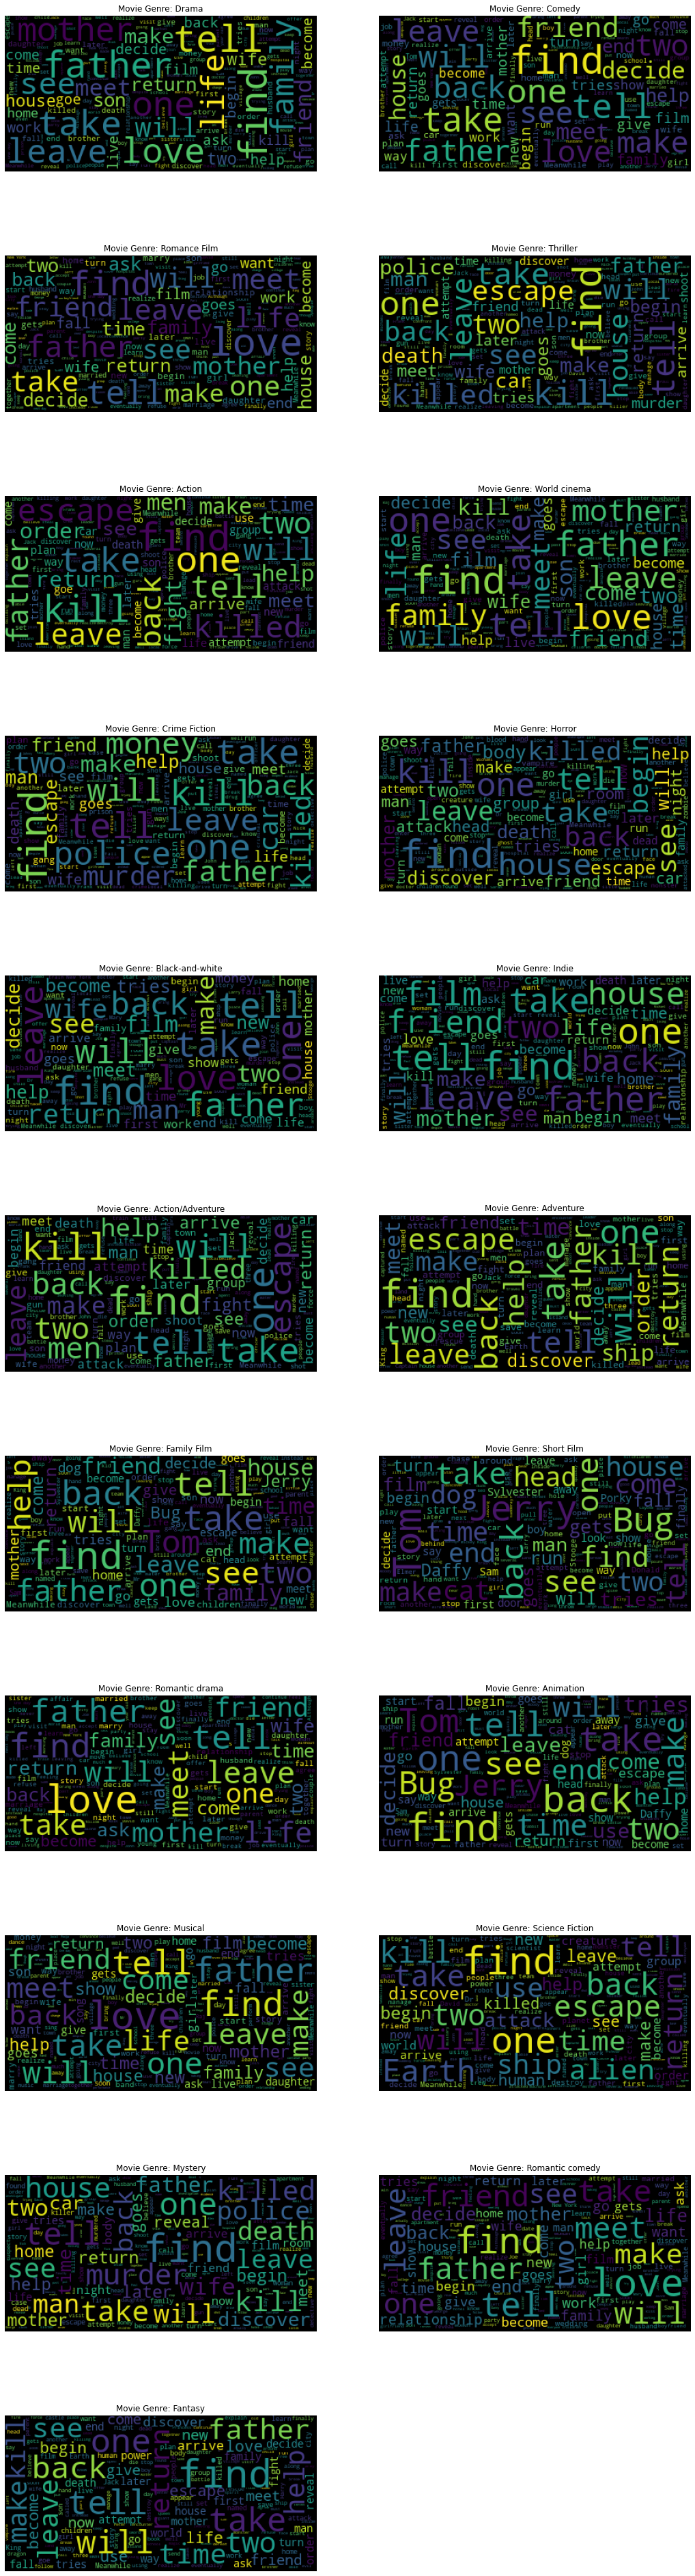

In [27]:
#Wordcloud plots for most frequent words appearing in each of the 21 genres
top21_categories = top_categories.Genre.to_list()
fig = plt.figure(figsize=(18, 70))
num_cols = 2
num_rows = math.ceil(len(top21_categories)/num_cols)
for idx, col in enumerate(top21_categories):
    wordcloud = WordCloud(max_font_size=50).generate(' '.join(movie_combined[movie_combined[col]==1]['Plot_Summary']))
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set(title='Movie Genre: {0}'.format(col))
plt.show()

Few observations from the above word cloud plots
- Words such as 'love', 'father', 'family', 'friend' are mostly seen in movies that belong to genre 'Drama'
- Few important words in 'Thriller' are 'police', 'find', 'kill', 'killed', 'escape'.
- Few important words in 'Action' are 'escape', 'find', 'kill', 'help'
- Few important words in 'Horror' are 'house', 'find', 'death', 'killed'
- Few important words in 'Animation' are 'Jerry', 'Tom', 'Bug'
- Few important words in 'Science Fiction' are 'Earth', 'ship', 'alien'

### 4. Text Preprocessing<a class="anchor" id="chapter4"></a>

We will use the text preprocessing techniques for the movie plot information:

1. Removing punctuations : We will remove all punctuations
2. Expand Contractions: Expand words like can't to can not, don't to do not, I'm to I am, etc.
3. Keep only alphabetic strings: Remove all non-alphabetic characters.
4. Lower Casing all the words: lower case the words
5. Removing 'english' stop words : We will use set of stop words provided by nltk. These stop words tend to appear more frequently and may not carry any useful information
6. Stemming or Lemmatization: These are the important normalizations methods. Stemming is a process of reducing words to their word stem, base or root form. Lemmatization on the other hand considers the context and converts the word to its meaningful base form.

In [28]:
#Remove Punctuations
def remove_punctuation(sentence):
    """
    Input :- String
    Output :- String after removing punctuations
    """
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

#Expand Contractions
def expand_contractions(sentence):
    """
    Input :- String
    Output :- String after expanding Contractions
    """
    cleaned_sentence = re.sub(r"what's", "what is", sentence)
    cleaned_sentence = re.sub(r"won't", "will not", cleaned_sentence)
    cleaned_sentence = re.sub(r"can't", "can not ", cleaned_sentence)
    
    cleaned_sentence = re.sub(r"\'s", " ", cleaned_sentence)
    cleaned_sentence = re.sub(r"\'ve", " have ", cleaned_sentence)
    cleaned_sentence = re.sub(r"\'re", " are ", cleaned_sentence)
    cleaned_sentence = re.sub(r"\'d", " would ", cleaned_sentence)
    cleaned_sentence = re.sub(r"\'ll", " will ", cleaned_sentence)
    cleaned_sentence = re.sub(r"\'m", " am", cleaned_sentence)
    cleaned_sentence = re.sub(r"n\'t", " not ", cleaned_sentence)
    
    return cleaned_sentence

#Keep alphabetic strings
def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

#Convert the string to lower case
def lower_case(sentence):
    """
    Input :- string
    Output :- lowercase string
    """
    lowercase_sentence = sentence.lower()
    return lowercase_sentence

#Apply stemming
def stemming(sentence):
    """
    Input :- string
    Output :- string after stemming
    """
    stemmer = PorterStemmer()
    #stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

#Apply lemmatization
def lemmatize_words(sentence):
    """
    Input :- string
    Output :- string after lemmatization
    """
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, pos='v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

#Remove stop words
def remove_stop_words(sentence):
    """
    Input :- string
    Output :- string after removing stop words
    """
    stop_words = set(stopwords.words('english'))
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_stop_sentence = ' '.join(no_stop_words)
    return no_stop_sentence

In [29]:
def text_preprocessing(sentence):
    """
    Input  : sentence
    Output : preprocessed text
    """
    pre_processed_sentence = remove_punctuation(sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    pre_processed_sentence = expand_contractions(pre_processed_sentence)
    #pre_processed_sentence = stemming(pre_processed_sentence) # Use Lemmatize instead of stemming
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

In [30]:
preprocessed_data = movie_combined[['Plot_Summary', 'Movie_genres']]
preprocessed_data['Plot_Summary'] = movie_combined['Plot_Summary'].apply(text_preprocessing)

In [31]:
preprocessed_data.head()
print("number of samples preprocessed dataset :", preprocessed_data.shape[0])

number of samples preprocessed dataset : 38979


### 5. Model Training and  Evaluation<a class="anchor" id="chapter5"></a>

#### 5.1 Train and Test Split<a class="anchor" id="section_5_1"></a>

Now let us split the dataset into training and test dataset. Here we can use scikit-multi-learn 'iterative_train_test_split' method to split our data with a training size of 67% and test size of 33% as this dataset has highly imbalanced classes. 'iterative_train_test_split' will sample the data using stratification to provide well balanced distribution of labels.

In [32]:
X = data_new[["Plot_Summary"]].values
y = GenreDF_new.values

from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.33)

print("Number of data samples in train data :", X_train.shape[0])
print("Number of data samples in test data :", X_test.shape[0])

Number of data samples in train data : 26146
Number of data samples in test data : 12833


In [33]:
#Tranforming X_train and X_test as pandas series
X_train = pd.Series(np.reshape(X_train, (X_train.shape[0], )))
X_test = pd.Series(np.reshape(X_test, (X_test.shape[0], )))

#Tranforming y_train and y_test to sparse matrix
y_train = sparse.csr_matrix(y_train)
y_test = sparse.csr_matrix(y_test)

#### 5.2 Model Training <a class="anchor" id="section_5_2"></a>

#### TFIDF Vectorizer
We need to prepare our raw text data before feeding to our model and for this purpose we will use TFIDF vectorizer. TFIDF vectorizer will convert the raw text in the plot summary to word frequency vectors . TFIDF stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This downscales words that appear a lot across documents.

#### Multi-Label Classifiers

There are multiple ways to transform our multi-label classification problem to multiple single-label problems. 

I have chosen to experiment with the following classifiers:
1. OneVsRest Classifier
2. Binary Relevance
3. Classifier Chain
4. Label Powerset


#### Naive Bayes Model
The above methods will need a classification algorithm and we will choose Naive Bayes model for this purpose.
<br>Naive Bayes is the most common algorithm used for text classification. Naive Bayes method uses the Bayes rule for classification of texts into one or more classes. It calculates the probability of an event occurring, based on certain other probabilities that are related to the event. 

Our plot information should be first transformed into vector representation and for this we will used TF-IDF vectorization before feeding to our Multinomial Naive Bayes Model.For this purpose, we will use the Pipeline feature from scikit-learn and process our training data and then train using Multinomial Naive Bayes model.

In [34]:
ModelsPerformance = {}

def Eval_metrics(test_labels, predict_labels):
    """
    Input :- test labels and predicted labels
    Output :- list of evaluation metrics like Hamming loss, Precision, Recall, F1-Score, ROC-AUC
    """
    #accuracy = metrics.accuracy_score(test_labels, predict_labels)
    hamming_loss = metrics.hamming_loss(test_labels,predict_labels)
    
    precision = precision_score(test_labels, predict_labels, average='micro')
    recall = recall_score(test_labels, predict_labels, average='micro')
    f1 = f1_score(test_labels, predict_labels, average='micro')
    roc_score = roc_auc_score(test_labels.toarray(),predict_labels.toarray())

    print("Hamming Loss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-measure: {:.4f}\nROC-AUC Score: {:.4f}"
          .format(hamming_loss, precision, recall, f1, roc_score))
    print("\n------ Classification Report ---------")
    print (metrics.classification_report(y_test, predict_labels))
    
    metricsdata = [hamming_loss, precision, recall, f1, roc_score]
    return metricsdata

# Function to visualize confusion matrix for each of the label
def plot_confusion_matrix(Confusion_Matrix):
    fig = plt.figure(figsize=(20, 25))

    num_cols = 4
    num_rows = math.ceil(len(top21_categories)/num_cols)
    for idx, col in enumerate(top21_categories):
        ax = fig.add_subplot(num_rows, num_cols, idx+1)
        sns.heatmap(Confusion_Matrix[idx], annot=True,fmt="d",cmap="Blues")
        ax.set(title='Movie Genre: {0}'.format(col))

    plt.show()

##### 5.2.1 OneVsRest Classifier<a class="anchor" id="section_5_2_1"></a>

In an “One-Vs-rest” strategy, our multi-label dataset is converted into multiple binary classification problems and then each of the binary classifier is then trained on each binary classification problem and choose the class for which the confidence is maximized.

In [ ]:
### This cell is not executed in this notebook due to time constraints
start = datetime.now()
classifier_1 = Pipeline([("tfidf_vect", TfidfVectorizer(norm='l2',smooth_idf=True)),
                        ("nb_model", OneVsRestClassifier(MultinomialNB()))])

#parameter search space
parameters = {"tfidf_vect__max_df": [0.5,0.1],
              "tfidf_vect__max_features": [10000,20000],
              "tfidf_vect__ngram_range": [(1,2), (1,3)],
              "nb_model__estimator__alpha":[0.001,0.01,0.1],
              "nb_model__estimator__fit_prior":[True, False]
             }

multi_nb_grid = GridSearchCV(classifier_1, param_grid=parameters, scoring='f1_micro', n_jobs=-1, cv=5, verbose=5)
multi_nb_grid.fit(X_train,y_train)
best_params = multi_nb_grid.best_params_
print("Best parameters:\n", best_params)
print("\nExecution Time:", datetime.now() - start)

------ Metrics: OneVsRestClassifier with Multinomial Naive Bayes Model -----
Hamming Loss: 0.1687
Precision: 0.3904
Recall: 0.7039
F1-measure: 0.5022
ROC-AUC Score: 0.7592

------ Classification Report ---------
              precision    recall  f1-score   support

           0       0.69      0.79      0.73      6314
           1       0.51      0.69      0.59      3454
           2       0.37      0.71      0.49      2200
           3       0.43      0.70      0.53      2155
           4       0.42      0.75      0.54      1936
           5       0.29      0.70      0.41      1700
           6       0.38      0.71      0.49      1411
           7       0.52      0.81      0.63      1347
           8       0.34      0.65      0.45      1231
           9       0.20      0.54      0.29      1210
          10       0.30      0.73      0.43      1172
          11       0.31      0.70      0.43      1072
          12       0.40      0.65      0.50      1062
          13       0.64      0.

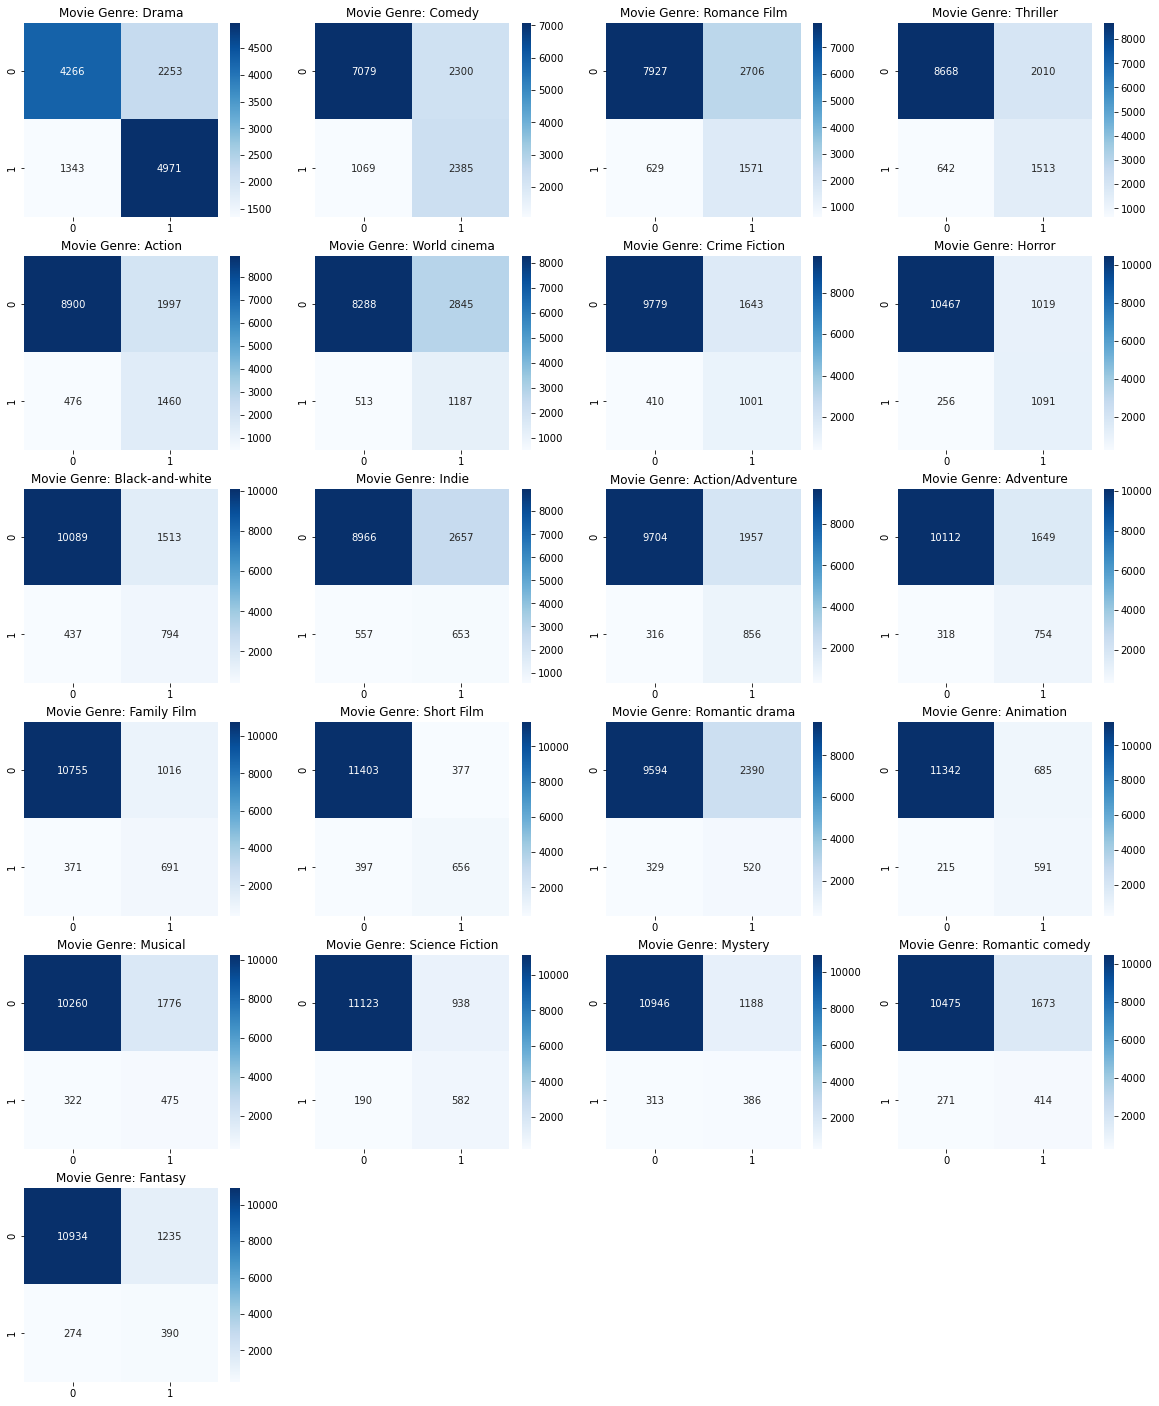

In [35]:
'''
Based on the parameters that gave the best scores from the grid search ran in previous notebooks, I have directly used the best
parameter values in the models
'''
best_params = {'nb_model__estimator__alpha': 0.001, 'nb_model__estimator__fit_prior': False, 'tfidf_vect__max_df': 0.1, 'tfidf_vect__max_features': 20000, 'tfidf_vect__ngram_range': (1, 2)}
start = datetime.now()
classifier_1 = Pipeline([("tfidf_vect", TfidfVectorizer(norm='l2',smooth_idf=True)),
                        ("nb_model", OneVsRestClassifier(MultinomialNB()))])

classifier_1.set_params(**best_params)
classifier_1.fit(X_train,y_train)
predictions_1 = classifier_1.predict(X_test)

print("------ Metrics: OneVsRestClassifier with Multinomial Naive Bayes Model -----")
ModelsPerformance['TF-IDF + OneVsRest + MultiNB'] = Eval_metrics(y_test, predictions_1)

print("\nExecution Time:", datetime.now() - start)

#Confusion Matrix
confusion_mx = metrics.multilabel_confusion_matrix(y_test, predictions_1)
plot_confusion_matrix(confusion_mx)

##### 5.2.2 Binary Relevance<a class="anchor" id="section_5_2_2"></a>

This is problem transformation method and works similar to OneVsRest Classifier, the problem is first transformed into multiple single-label binary classification problem, one for each class. Build N different binary classifiers for each of the N classes. Each classifier then checks the relevance of that particular class.

------ Metrics: BinaryRelevance with Multinomial Naive Bayes Model -----
Hamming Loss: 0.1687
Precision: 0.3904
Recall: 0.7039
F1-measure: 0.5022
ROC-AUC Score: 0.7592

------ Classification Report ---------
              precision    recall  f1-score   support

           0       0.69      0.79      0.73      6314
           1       0.51      0.69      0.59      3454
           2       0.37      0.71      0.49      2200
           3       0.43      0.70      0.53      2155
           4       0.42      0.75      0.54      1936
           5       0.29      0.70      0.41      1700
           6       0.38      0.71      0.49      1411
           7       0.52      0.81      0.63      1347
           8       0.34      0.65      0.45      1231
           9       0.20      0.54      0.29      1210
          10       0.30      0.73      0.43      1172
          11       0.31      0.70      0.43      1072
          12       0.40      0.65      0.50      1062
          13       0.64      0.62  

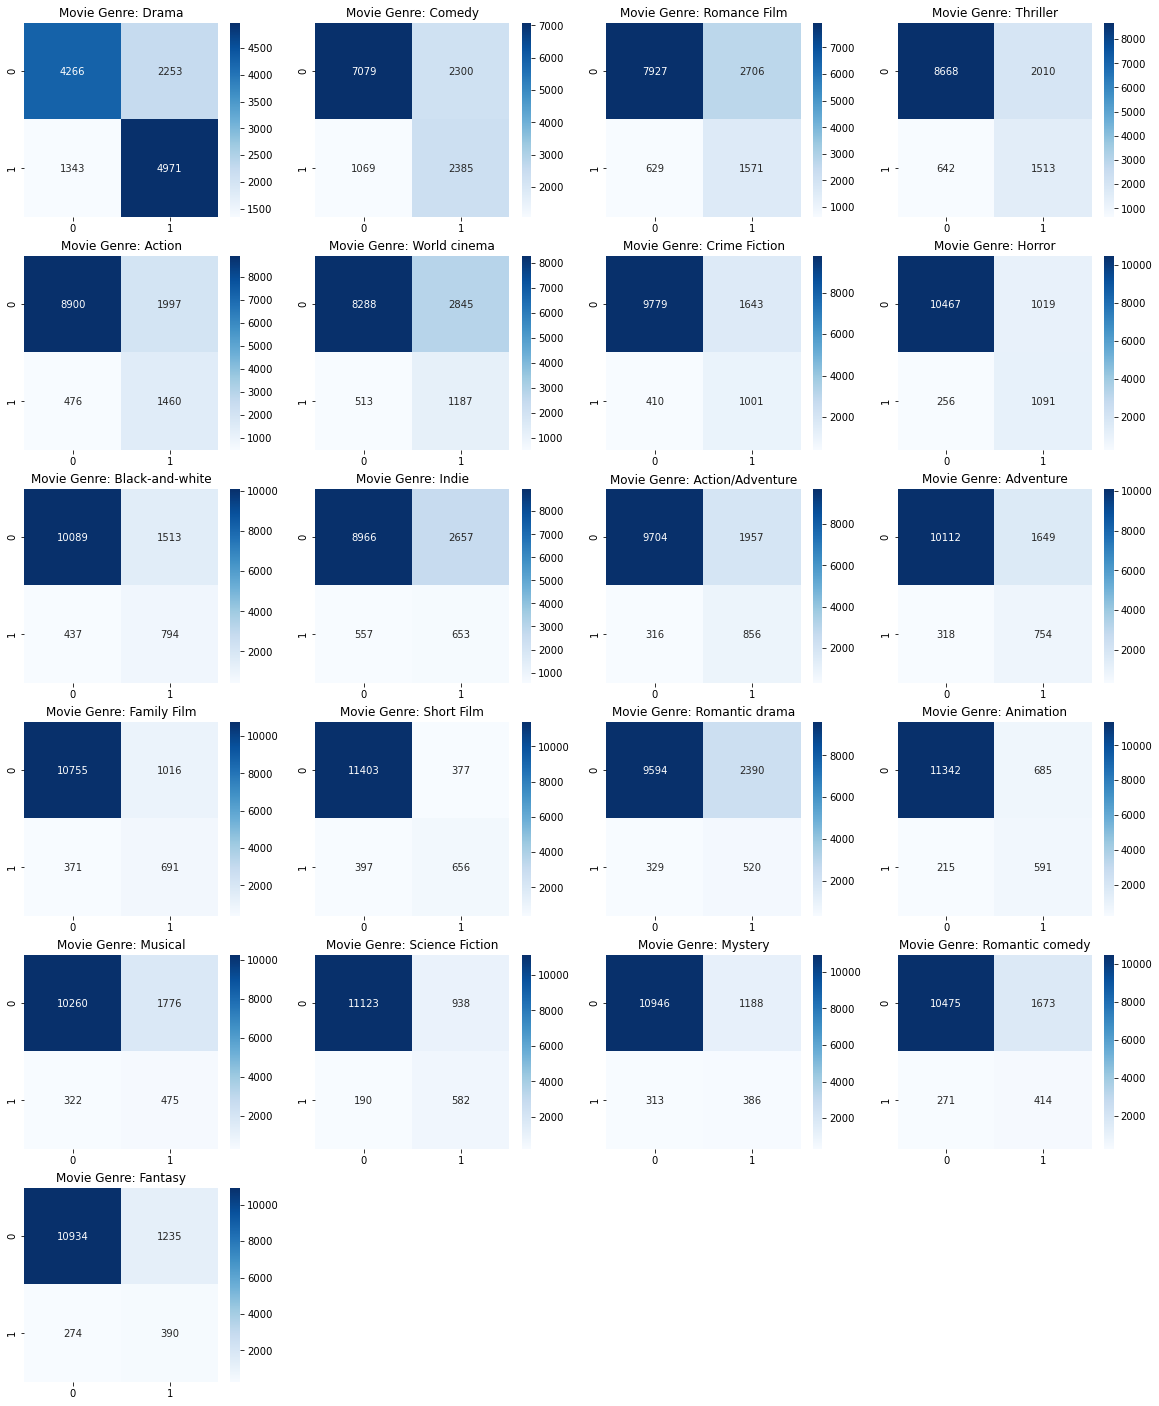

In [36]:
#Parameter Setting
best_params = {'br_model__classifier__alpha': 0.001, 'br_model__classifier__fit_prior': False, 'tfidf_vect__max_df': 0.1, 'tfidf_vect__max_features': 20000, 'tfidf_vect__ngram_range': (1, 2)}

start = datetime.now()
classifier_2 = Pipeline([("tfidf_vect", TfidfVectorizer(norm='l2',smooth_idf=True)),
                        ("br_model", BinaryRelevance(MultinomialNB()))])

classifier_2.set_params(**best_params)
classifier_2.fit(X_train, y_train)
predictions_2 = classifier_2.predict(X_test)

print("------ Metrics: BinaryRelevance with Multinomial Naive Bayes Model -----")
ModelsPerformance["TF-IDF + BR + MultiNB"] = Eval_metrics(y_test, predictions_2)

print("\nExecution Time:", datetime.now() - start)

#Confusion Matrix
confusion_mx = metrics.multilabel_confusion_matrix(y_test, predictions_2)
plot_confusion_matrix(confusion_mx)

#### Example of the predicted labels

In [57]:
print("******************Plot Description**************************\n")
print(X_test[30])
multi_y = MultiLabelBinarizer()
multi_y.fit_transform(movie_combined['Movie_genres'])
print("\n*****************Predicted Genres***************************\n")
print(multi_y.inverse_transform(predictions_2[30]))

******************Plot Description**************************

{{Plot}} Husband and wife Rawdon  and Miranda  are soulmates. Their love for each other is palpable as they lie in bed treasuring their 6 month old daughter Quincey. Miranda fantasizes about the speech she plans to make when, one day in their future, she will give this tiny infant away at her wedding. Tragically, when Quincey is 3, Miranda is killed in a car accident and Rawdon is left alone, unmoored, to continue life without the love of his life. Fortunately Rawdon still has Quincey. Staying as strong as he can he takes her to the roof of a skyscraper and explains that Mommy is now an angel. It is up here that for the first time they see a vision of Miranda as an angel. Rawdon continues to see visions of her. Initially these visions help him—at home she gives him advice about parenting; in Portugal she softens his hardness; when he hides in the closet to isolate himself she snaps some sense into him and insists that Rawdon

In [58]:
print("\n*****************Actual Genres***************************\n")
print(multi_y.inverse_transform(y_test[30]))


*****************Actual Genres***************************

[('Action', 'Adventure', 'Romance Film')]


From the above plot and the different words that appear, it has been labelled into ''Action', 'Action/Adventure', 'Adventure', 'Romance Film', 'Thriller' categories.
Words like love, father, mother appears for 'Romance Film', 'Action' and 'Adventure' includes words like killed, help, find,leave

##### 5.2.3 Classifier Chain<a class="anchor" id="section_5_2_3"></a>

Binary Relevance is considered as the simplest problem transformation method but this does not consider the correlations in the labels. To rectify this, we will use Classifier chain.
A chain of binary classifiers C0, C1, . . . , Cn are created, where classifier Cj in the chain learns and predicts the binary association of label lj. The classification starts with C1 and then propagates through C2 and so on until Cn.

------ Metrics: Classifier Chain with Multinomial Naive Bayes Model -----
Hamming Loss: 0.2091
Precision: 0.3295
Recall: 0.7043
F1-measure: 0.4490
ROC-AUC Score: 0.7459

------ Classification Report ---------
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      6314
           1       0.51      0.65      0.57      3454
           2       0.36      0.75      0.48      2200
           3       0.42      0.65      0.51      2155
           4       0.38      0.74      0.50      1936
           5       0.27      0.71      0.40      1700
           6       0.32      0.69      0.43      1411
           7       0.51      0.75      0.61      1347
           8       0.33      0.53      0.41      1231
           9       0.19      0.55      0.28      1210
          10       0.25      0.78      0.38      1172
          11       0.25      0.72      0.37      1072
          12       0.42      0.59      0.49      1062
          13       0.52      0.61 

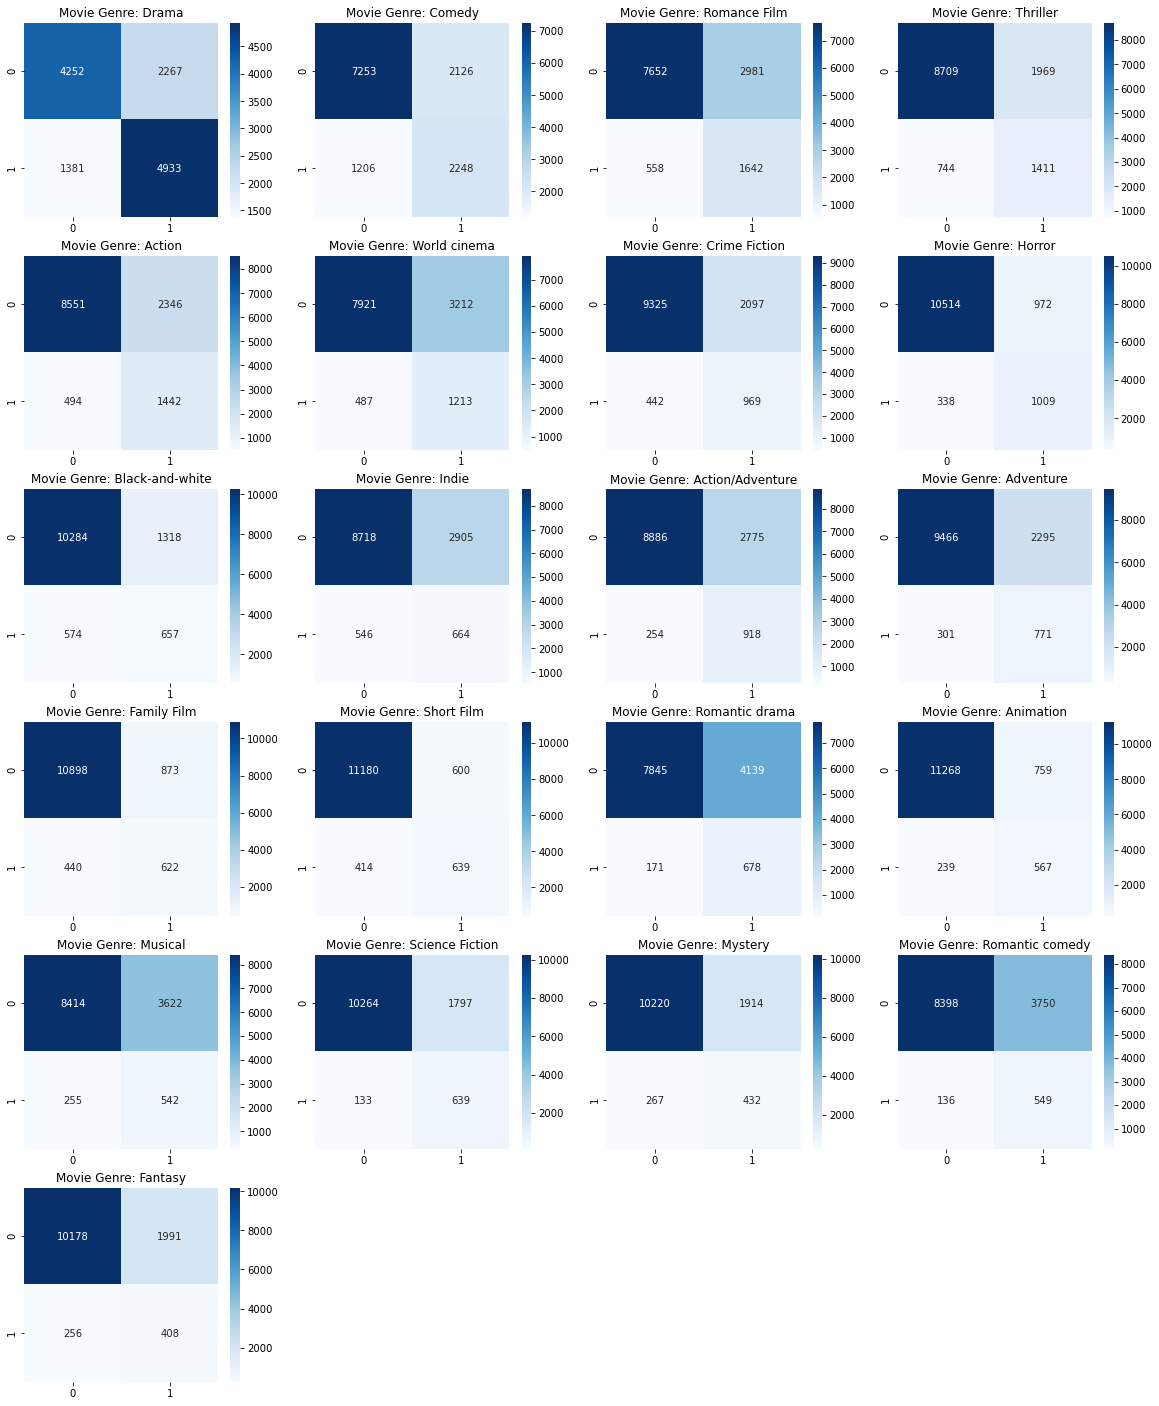

In [39]:
#Parameter Setting
best_params = {'cc_model__classifier__alpha': 0.001, 'cc_model__classifier__fit_prior': False, 'tfidf_vect__max_df': 0.1, 'tfidf_vect__max_features': 20000, 'tfidf_vect__ngram_range': (1, 3)}

start = datetime.now()
classifier_3 = Pipeline([("tfidf_vect", TfidfVectorizer(norm='l2',smooth_idf=True)),
                        ("cc_model", ClassifierChain(MultinomialNB()))])

classifier_3.set_params(**best_params)
classifier_3.fit(X_train, y_train)
predictions_3 = classifier_3.predict(X_test)

print("------ Metrics: Classifier Chain with Multinomial Naive Bayes Model -----")
ModelsPerformance["TF-IDF + CC + MultiNB"] = Eval_metrics(y_test, predictions_3)

print("\nExecution Time:", datetime.now() - start)

#Confusion Matrix
confusion_mx = metrics.multilabel_confusion_matrix(y_test, predictions_3)
plot_confusion_matrix(confusion_mx)

##### 5.2.4 Label Powerset<a class="anchor" id="section_5_2_4"></a>
This is another problem transformation method that transforms our multi-label problem into single multi-class problem and use any multi-class classifier to train all unique label combinations found in the training data.

------ Metrics: Label Powerset with Multinomial Naive Bayes Model -----
Hamming Loss: 0.1298
Precision: 0.4540
Recall: 0.3632
F1-measure: 0.4036
ROC-AUC Score: 0.6046

------ Classification Report ---------
              precision    recall  f1-score   support

           0       0.65      0.72      0.69      6314
           1       0.51      0.49      0.50      3454
           2       0.33      0.23      0.27      2200
           3       0.37      0.18      0.24      2155
           4       0.40      0.29      0.34      1936
           5       0.26      0.16      0.20      1700
           6       0.31      0.15      0.20      1411
           7       0.54      0.66      0.60      1347
           8       0.33      0.17      0.22      1231
           9       0.13      0.05      0.07      1210
          10       0.30      0.22      0.25      1172
          11       0.31      0.26      0.28      1072
          12       0.41      0.34      0.37      1062
          13       0.67      0.43   

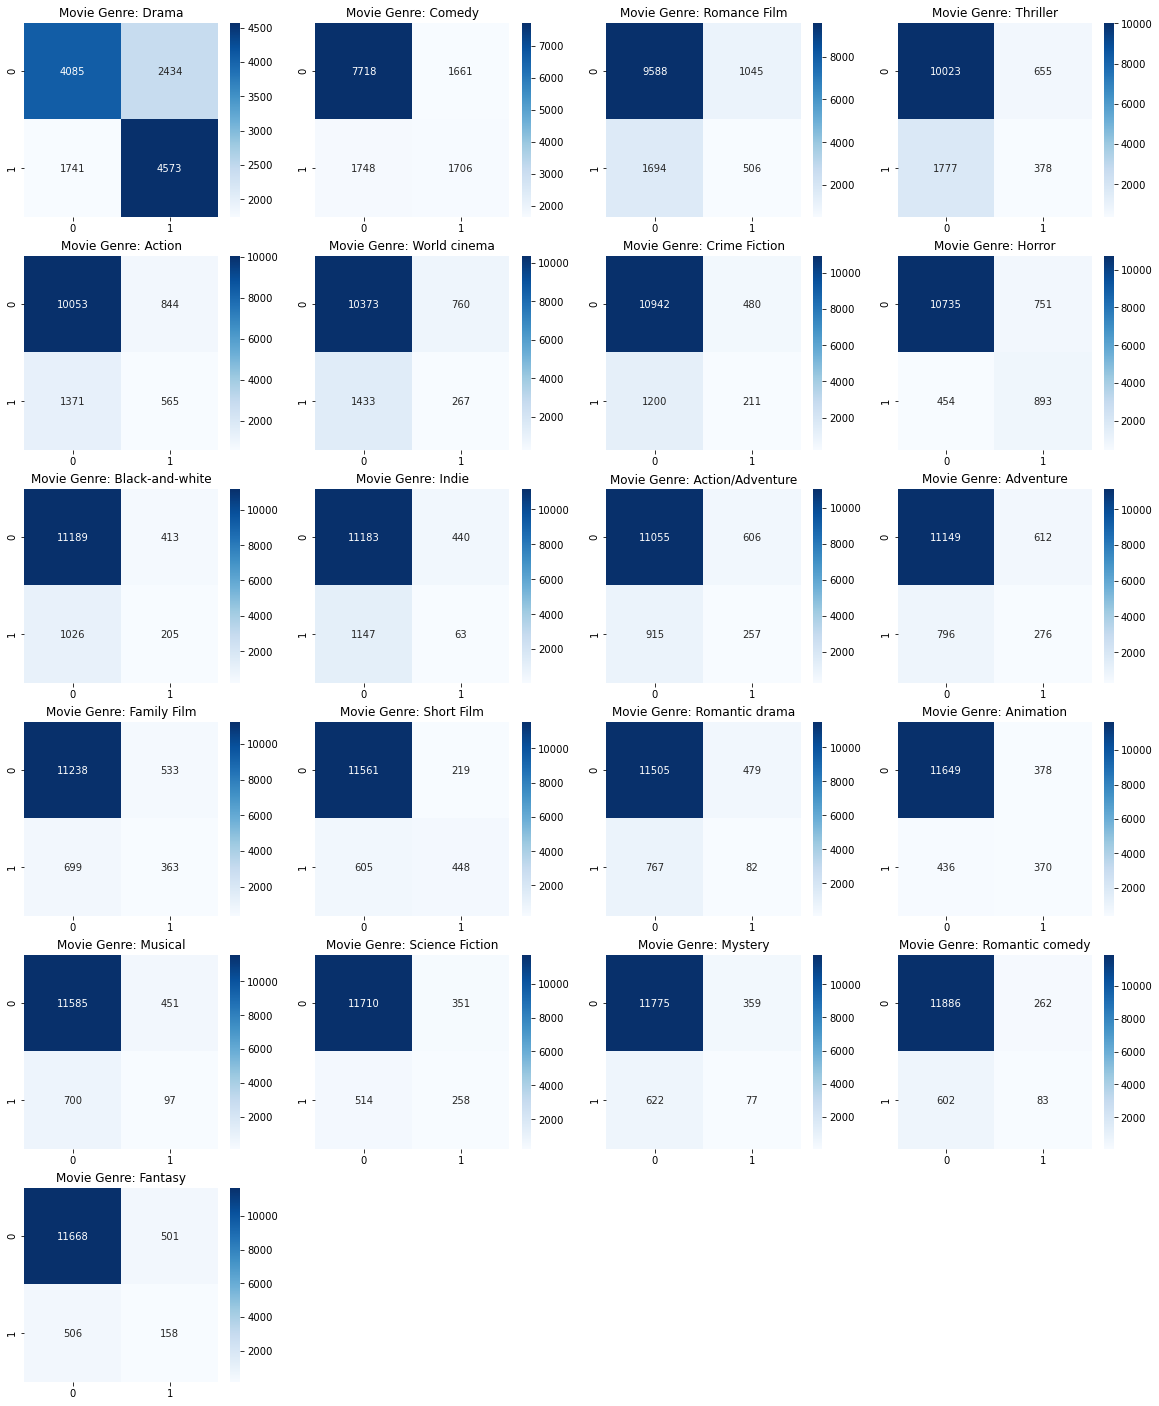

In [40]:
#Parameter Setting
best_params = {'lp_model__classifier__alpha': 0.001, 'lp_model__classifier__fit_prior': False, 'tfidf_vect__max_df': 0.1, 'tfidf_vect__max_features': 20000, 'tfidf_vect__ngram_range': (1, 2)}

start = datetime.now()
classifier_4 = Pipeline([("tfidf_vect", TfidfVectorizer(norm='l2',smooth_idf=True)),
                        ("lp_model", LabelPowerset(MultinomialNB()))])

classifier_4.set_params(**best_params)
classifier_4.fit(X_train, y_train)
predictions_4 = classifier_4.predict(X_test)

print("------ Metrics: Label Powerset with Multinomial Naive Bayes Model -----")
ModelsPerformance["TF-IDF + LP + MultiNB"] = Eval_metrics(y_test, predictions_4)

print("\nExecution Time:", datetime.now() - start)

#Confusion Matrix
confusion_mx = metrics.multilabel_confusion_matrix(y_test, predictions_4)
plot_confusion_matrix(confusion_mx)

### 6. Results and Conclusion <a class="anchor" id="chapter6"></a>

From the table below, we have trained the below 4 models(setups) to predict all the genres(top 21 genres) based on the movie plot information.

1. TF-IDF vectorization + OneVsRestClassifier + Multinomial Naive Bayes
2. TF-IDF vectorization + Binary Relevance + Multinomial Naive Bayes
3. TF-IDF vectorization + Classifier Chain + Multinomial Naive Bayes
4. TF-IDF vectorization + Label PowerSet + Multinomial Naive Bayes

<br> Parameters for Multinomial Naive Bayes -> 'alpha': 0.001, 'fit_prior': False
<br> Parameters for TF-IDF                  -> 'max_df': 0.1, 'max_features': 20000, 'ngram_range': (1, 2)

In [41]:
results = pd.DataFrame.from_dict(ModelsPerformance, orient='index',columns=['Hamming Loss', 'Precision', 'Recall','F1-Score','ROC-AUC'])
print("------------------------- CONSOLIDATED EVALUATION METRICS ---------------\n")
results

------------------------- CONSOLIDATED EVALUATION METRICS ---------------



Hamming Loss  Precision    Recall  F1-Score  \
TF-IDF + OneVsRest + MultiNB      0.168743   0.390366  0.703949  0.502228   
TF-IDF + BR + MultiNB             0.168743   0.390366  0.703949  0.502228   
TF-IDF + CC + MultiNB             0.209074   0.329496  0.704317  0.448958   
TF-IDF + LP + MultiNB             0.129825   0.454008  0.363190  0.403553   

                               ROC-AUC  
TF-IDF + OneVsRest + MultiNB  0.759243  
TF-IDF + BR + MultiNB         0.759243  
TF-IDF + CC + MultiNB         0.745888  
TF-IDF + LP + MultiNB         0.604609

The average overall Precision, Recall and F1-score for every model is listed above.
- Binary Relevance and OneVsRest Classifier have the best values of F1-Score of 0.50 and ROC-AUC 0.76 as compare to classifier chains and Label Powerset. The scores in general are not good due the class imbalance.
- Naive Bayes algorithm with TFIDF can be considered as a base model and I expect that complex models like LSTM or BERT can work out even better to solve such multi-label classification problems.
- Based on the above results, the best model uses TF-IDF Vectorizer Binary Relevance with Multi Naive Bayes approach to make multi-label classification and achieves an overall F1 score of 0.50